In [35]:
#from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import scipy

from sklearn.model_selection import train_test_split
 

In [41]:
!nvidia-smi

Fri May 28 16:54:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:82:00.0 Off |                    0 |
| N/A   31C    P0    34W / 250W |  15749MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
path = './all/'
count = 0
for root,dirs,files in os.walk(path):
      for each in files:
          if each.endswith('png'):
             count += 1
print ("圖片數量：",count)

圖片數量： 54415


# 1. Data Exploration

In [2]:
df = pd.read_excel("liddar_img_v2.xlsx")
print(df.shape)
print(df.head(3))

(2262, 3)
                image    False_Reason Label
0  9622-1-029_001.png  Electric Tower     Y
1  9622-1-029_002.png  Electric Tower     Y
2  9622-1-030_001.png  Electric Tower     Y


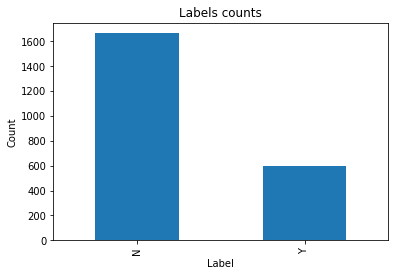

In [4]:
df.Label.value_counts().plot(kind='bar')
plt.style.use('fast')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [18]:
class ImageViewer:
    def read_img(self,id):
        """
        Read image by it's id
        """
        file='./all/'+ str(id)
        im=cv2.imread(file)
        return im

    def draw_sample_images(self):
        """
        Draw cancer and healthy images for EDA
        """
        ncols=4
        plt.style.use('default')
        f, ax = plt.subplots(nrows=2,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=['N', 'Y']
        # Draw one row for cancer, one row for healthy images
        for label in ['N','Y']:
            i=i+1
            samples = df[df['Label']==label]['image'].sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=self.read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

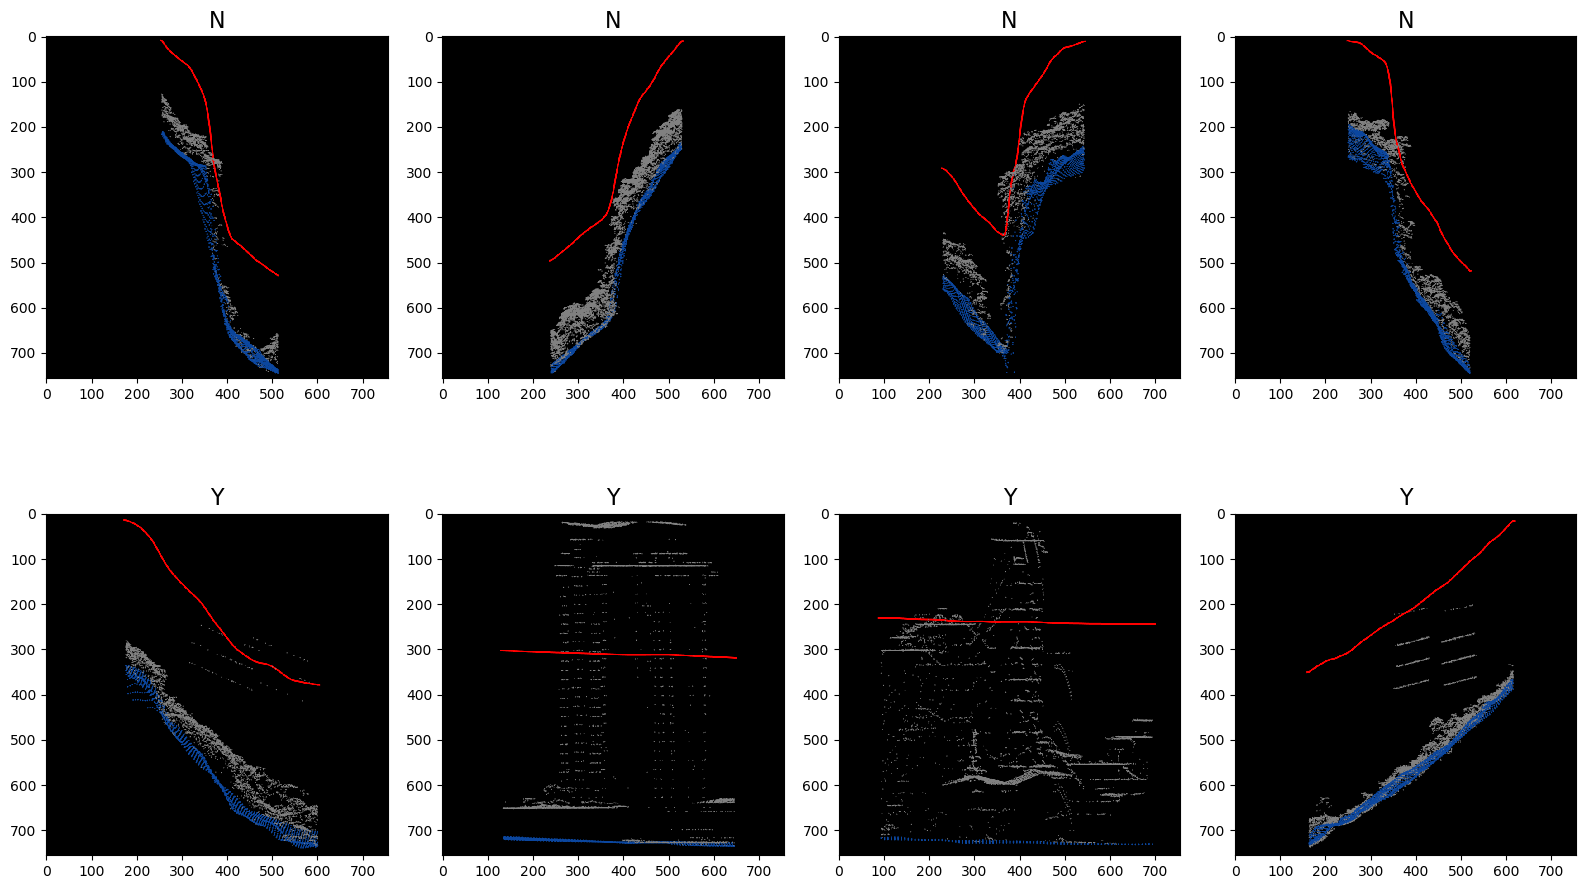

In [19]:
ImageViewer().draw_sample_images()

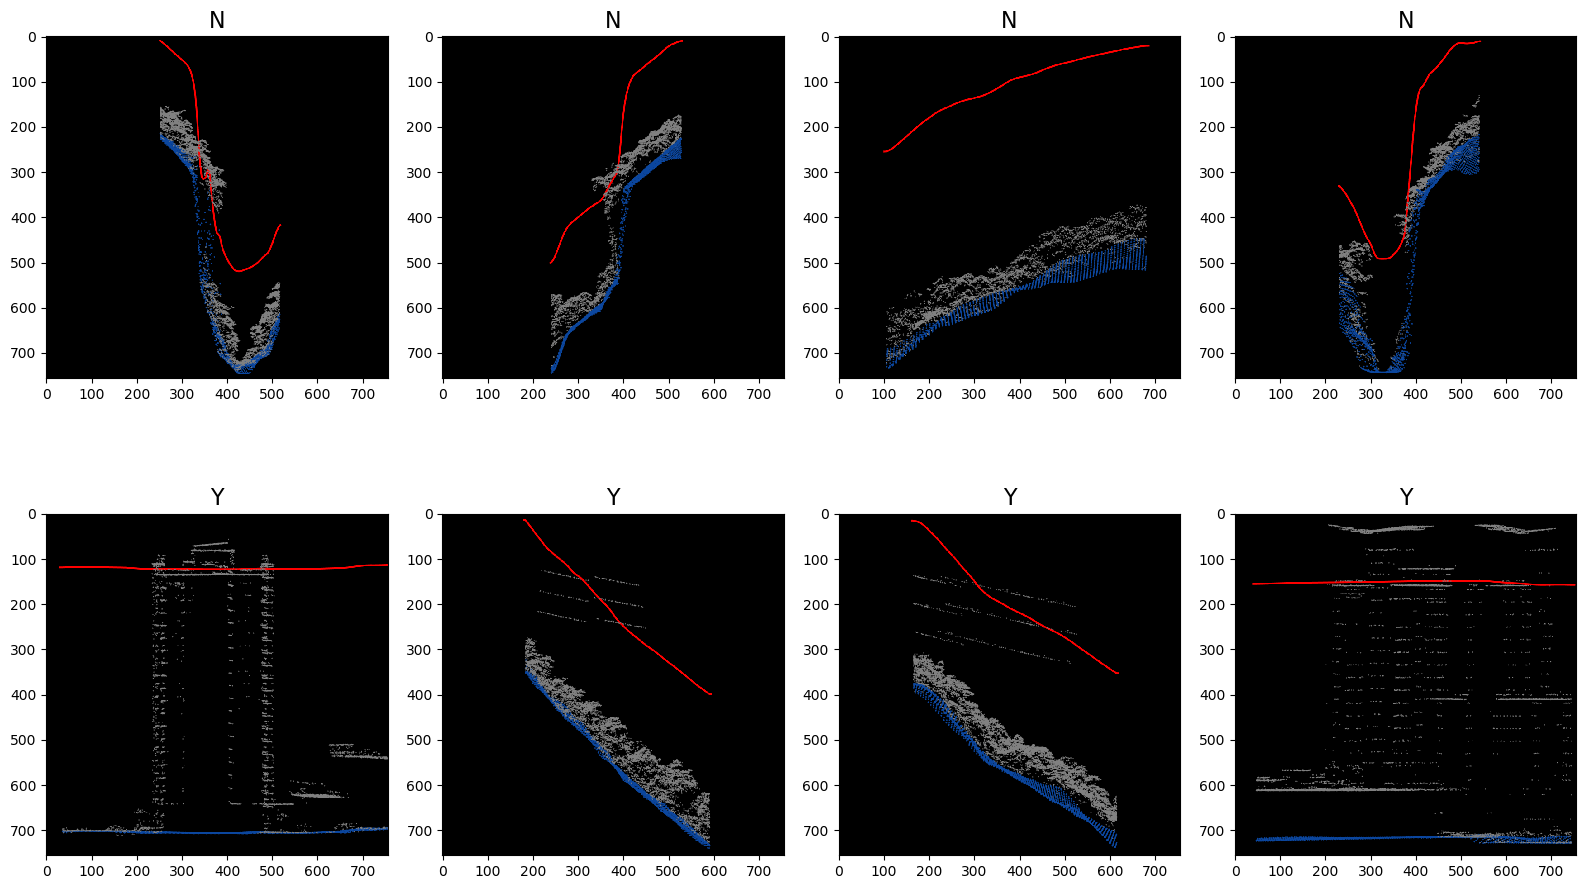

In [20]:
ImageViewer().draw_sample_images()

# 2. Data Preprocess
首先創建function **img_pre**, 將參考線與地表基線移除. 只判斷目標物. 並且加強目標物像素到255 (光達圖回波資料弱,不代表物體存在度低).

In [30]:
def img_pre(img):
    img = img[ : , : , (2, 1, 0)]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # (0,0,B):(0,0,0)
            if((img[i][j][2]!=0) and (img[i][j][0]==0) and (img[i][j][1]==0)):
                img[i][j][2]=0
            # (R,0,0):(0,0,0)
            if((img[i][j][0]!=0) and (img[i][j][1]==0) and (img[i][j][2]==0)):
                img[i][j][0]=0
            # R=B=G: (255,255,255) & keep (0,0,0)
            if((img[i][j][0]==img[i][j][1]) and (img[i][j][1]==img[i][j][2]) and (img[i][j][0]!=0)):
                img[i][j][0]=255;img[i][j][1]=255;img[i][j][2]=255      
            # B>R & G:(0,0,0)
            if(img[i][j][2]>img[i][j][1]):
                if(img[i][j][2]>img[i][j][0]):
                    img[i][j][1]=0;img[i][j][0]=0;img[i][j][2]=0
            # R>G & B:(0,0,0)
            if(img[i][j][0]>img[i][j][1]):
                if(img[i][j][0]>img[i][j][2]):
                    img[i][j][1]=0;img[i][j][2]=0;img[i][j][0]=0
    return img

In [31]:
from numpy.random import randint
def img_compare(img_file,path):
    ix = randint(0, count, 1)
    file=img_file[ix[0]]
    img=cv2.imread(path+file)
    img = img[ : , : , (2, 1, 0)]
    img2=img_pre(img)
    plt.figure(figsize=(14,14))
    plt.subplot(1,2,1)
    plt.imshow(img);plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img2);plt.axis('off')
    print(file)

In [32]:
# read all img file
path = './all/'
img_file=[]
for root,dirs,files in os.walk(path):
      for each in files:
            if each.endswith('png'):
                img_file.append(each)

9519-2-006_007.png


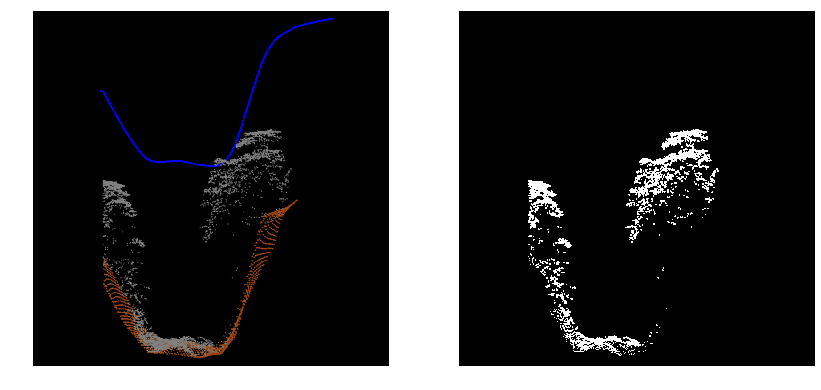

In [9]:
img_compare(img_file,path)

9622-1-030_004.png


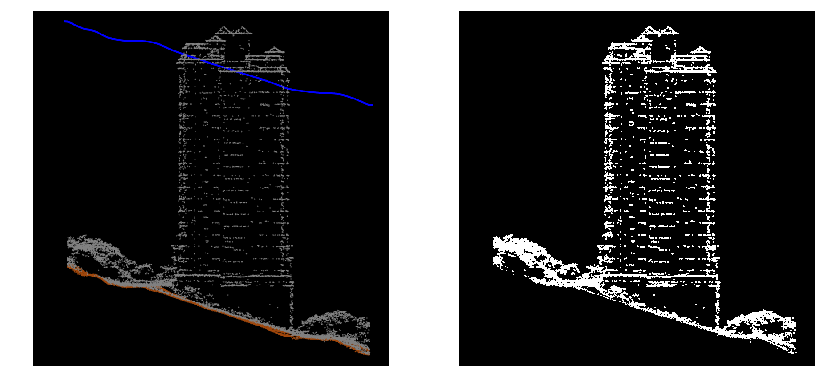

In [38]:
file="9622-1-030_004.png"
img=cv2.imread(path+file)
img = img[ : , : , (2, 1, 0)]
img2=img_pre(img)
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
plt.imshow(img);plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2);plt.axis('off')
print(file)

In [61]:
from numpy import asarray
from numpy import savez_compressed
def load_images(path):
    img_list = list()
    for i in range(df.shape[0]):
        print(i+1,df['image'][i])
        # load and resize the image
        filename=df['image'][i]
        img = cv2.imread(path+filename)
        # img process
        img = img[ : , : , (2, 1, 0)]
        img = img_pre(img)
        # merge
        img_list.append(img.tolist())
        # 防呆 避免記憶體over loading而中斷, 每200次存一次檔案
        if((i+1)%200==0):
            images=asarray(img_list)
            filename = 'tree.npz'
            savez_compressed(filename, images)
            print(images.shape)
    return asarray(img_list)

In [ ]:
images = load_images(path)
print('Loaded: ', images.shape)

1 9622-1-029_001.png
2 9622-1-029_002.png
3 9622-1-030_001.png
4 9622-1-030_002.png
5 9622-1-030_003.png
6 9622-1-030_004.png
7 9622-1-030_005.png
8 9622-1-030_006.png
9 9622-1-030_007.png
10 9622-1-030_008.png
11 9622-1-030_009.png
12 9622-1-030_010.png
13 9622-1-030_011.png
14 9622-1-030_012.png
15 9622-1-030_013.png
16 9622-1-030_014.png
17 9622-1-030_015.png
18 9622-1-030_016.png
19 9622-1-030_017.png
20 9622-1-030_018.png
21 9622-1-030_020.png
22 9622-1-030_021.png
23 9622-1-030_022.png
24 9622-1-030_023.png
25 9622-1-030_024.png
26 9622-1-036_001.png
27 9622-1-036_002.png
28 9622-1-042_001.png
29 9622-1-043_001.png
30 9622-1-045_001.png
31 9622-1-045_002.png
32 9622-1-046_001.png
33 9622-1-048_001.png
34 9622-1-048_084.png
35 9622-1-048_086.png
36 9622-1-048_087.png
37 9622-1-049_020.png
38 9622-1-049_038.png
39 9622-1-049_039.png
40 9622-1-049_040.png
41 9622-1-049_041.png
42 9622-1-049_053.png
43 9622-1-049_054.png
44 9622-1-049_055.png
45 9622-1-049_112.png
46 9622-1-049_113.p

362 9722-4-012_141.png
363 9722-4-012_142.png
364 9722-4-012_145.png
365 9722-4-012_146.png
366 9722-4-012_147.png
367 9722-4-012_148.png
368 9722-4-012_149.png
369 9722-4-012_150.png
370 9722-4-012_151.png
371 9722-4-012_153.png
372 9722-4-012_154.png
373 9722-4-012_159.png
374 9722-4-012_161.png
375 9722-4-012_166.png
376 9722-4-012_167.png
377 9722-4-012_169.png
378 9722-4-012_170.png
379 9722-4-012_171.png
380 9722-4-012_172.png
381 9722-4-012_173.png
382 9722-4-012_174.png
383 9722-4-012_175.png
384 9722-4-012_176.png
385 9722-4-012_178.png
386 9722-4-012_180.png
387 9722-4-012_181.png
388 9722-4-012_182.png
389 9722-4-012_184.png
390 9722-4-012_185.png
391 9722-4-012_186.png
392 9722-4-012_187.png
393 9722-4-012_188.png
394 9722-4-012_189.png
395 9722-4-012_190.png
396 9722-4-012_191.png
397 9722-4-012_192.png
398 9722-4-012_193.png
399 9722-4-012_194.png
400 9722-4-012_195.png
(400, 756, 756, 3)
401 9722-4-012_196.png
402 9722-4-012_197.png
403 9722-4-012_198.png
404 9722-4-012_

717 9621-1-070_024.png
718 9621-1-070_025.png
719 9621-1-070_026.png
720 9621-1-070_027.png
721 9621-1-070_028.png
722 9621-1-070_029.png
723 9621-1-070_030.png
724 9621-1-070_031.png
725 9621-1-070_032.png
726 9621-1-070_033.png
727 9621-1-070_034.png
728 9621-1-070_035.png
729 9621-1-070_036.png
730 9621-1-070_037.png
731 9621-1-070_038.png
732 9621-1-070_039.png
733 9621-1-070_040.png
734 9621-1-070_041.png
735 9621-1-070_042.png
736 9621-1-070_043.png
737 9621-1-070_044.png
738 9621-1-070_045.png
739 9622-1-037_001.png
740 9622-1-044_055.png
741 9622-1-067_001.png
742 9622-1-067_002.png
743 9622-1-067_003.png
744 9622-1-067_004.png
745 9622-1-067_005.png
746 9622-1-083_002.png
747 9622-1-084_043.png
748 9622-1-084_044.png
749 9622-1-084_045.png
750 9622-1-085_001.png
751 9622-1-085_002.png
752 9622-1-085_003.png
753 9622-1-085_004.png
754 9622-1-087_001.png
755 9622-1-090_001.png
756 9622-1-091_001.png
757 9622-1-091_002.png
758 9622-1-091_003.png
759 9622-1-092_001.png
760 9622-1-

1069 9622-2-042_004.png
1070 9622-2-042_005.png
1071 9622-2-042_006.png
1072 9622-2-042_007.png
1073 9622-2-042_008.png
1074 9622-2-042_009.png
1075 9622-2-042_011.png
1076 9622-2-042_012.png
1077 9622-2-043_001.png
1078 9622-2-043_002.png
1079 9622-2-044_001.png
1080 9622-2-044_004.png
1081 9622-2-048_001.png
1082 9622-2-048_002.png
1083 9622-2-048_003.png
1084 9622-2-048_004.png
1085 9622-2-048_005.png
1086 9622-2-048_008.png
1087 9622-2-048_009.png
1088 9622-2-048_010.png
1089 9622-2-048_011.png
1090 9622-2-048_012.png
1091 9622-2-048_013.png
1092 9622-2-048_014.png
1093 9622-2-048_015.png
1094 9622-2-048_016.png
1095 9622-2-048_017.png
1096 9622-2-048_018.png
1097 9622-2-048_019.png
1098 9622-2-048_020.png
1099 9622-2-048_021.png
1100 9622-2-048_022.png
1101 9622-2-048_023.png
1102 9622-2-048_024.png
1103 9622-2-048_025.png
1104 9622-2-048_026.png
1105 9622-2-048_027.png
1106 9622-2-048_028.png
1107 9622-2-048_029.png
1108 9622-2-048_030.png
1109 9622-2-048_031.png
1110 9622-2-048_

1409 9721-4-013_006.png
1410 9721-4-013_007.png
1411 9721-4-013_008.png
1412 9721-4-013_009.png
1413 9721-4-013_010.png
1414 9721-4-013_011.png
1415 9721-4-013_012.png
1416 9721-4-014_001.png
1417 9721-4-014_002.png
1418 9721-4-015_001.png
1419 9721-4-015_002.png
1420 9721-4-015_003.png
1421 9721-4-015_004.png
1422 9721-4-016_001.png
1423 9721-4-016_002.png
1424 9721-4-017_001.png
1425 9721-4-017_002.png
1426 9721-4-017_003.png
1427 9721-4-017_004.png
1428 9721-4-017_005.png
1429 9721-4-018_001.png
1430 9721-4-018_002.png
1431 9721-4-020_001.png
1432 9721-4-021_001.png
1433 9721-4-021_002.png
1434 9721-4-023_001.png
1435 9721-4-024_001.png
1436 9721-4-024_002.png
1437 9721-4-024_003.png
1438 9721-4-024_004.png
1439 9721-4-024_005.png
1440 9721-4-024_006.png
1441 9721-4-024_009.png
1442 9721-4-024_010.png
1443 9721-4-024_012.png
1444 9721-4-024_013.png
1445 9721-4-024_015.png
1446 9721-4-024_016.png
1447 9721-4-024_017.png
1448 9721-4-024_018.png
1449 9721-4-024_019.png
1450 9721-4-024_

1750 9721-4-056_056.png
1751 9721-4-056_057.png
1752 9721-4-056_058.png
1753 9721-4-056_059.png
1754 9721-4-056_060.png
1755 9721-4-056_061.png
1756 9721-4-056_062.png
1757 9721-4-056_063.png
1758 9721-4-056_064.png
1759 9721-4-056_065.png
1760 9721-4-056_066.png
1761 9721-4-056_067.png
1762 9721-4-056_068.png
1763 9721-4-056_069.png
1764 9721-4-056_071.png
1765 9721-4-056_072.png
1766 9721-4-056_074.png
1767 9721-4-056_075.png
1768 9721-4-056_076.png
1769 9721-4-056_077.png
1770 9721-4-056_078.png
1771 9721-4-056_079.png
1772 9721-4-056_080.png
1773 9721-4-056_081.png
1774 9721-4-056_082.png
1775 9721-4-056_083.png
1776 9721-4-056_084.png
1777 9721-4-056_086.png
1778 9721-4-056_087.png
1779 9721-4-056_088.png
1780 9721-4-056_089.png
1781 9721-4-056_090.png
1782 9721-4-056_091.png
1783 9721-4-056_092.png
1784 9721-4-056_093.png
1785 9721-4-056_094.png
1786 9721-4-056_095.png
1787 9721-4-056_096.png
1788 9721-4-056_097.png
1789 9721-4-056_098.png
1790 9721-4-056_099.png
1791 9721-4-056_

In [ ]:
#整體再存一次檔
filename = 'tree.npz'
savez_compressed(filename, images)

In [3]:
# load and prepare training images
from numpy import load
data = load('tree.npz')
X = data['arr_0']
print(X.shape)

(2262, 756, 756, 3)


In [4]:
Y = np.array(df['Label'])
print(Y.shape)

(2262,)


In [5]:
np.place(Y,Y=="Y",1)
np.place(Y,Y=="N",0)
Y

array([1, 1, 1, ..., 0, 0, 0], dtype=object)

# 3. Model Training

In [6]:
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
#from keras.utils import conv_utils
#from keras.utils.data_utils import get_file
#from keras.engine.topology import get_source_inputs
#from keras.applications.resnet50 import preprocess_input
#from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras import layers, Input, models
import tensorflow as tf

Using TensorFlow backend.


In [7]:
# Split the 'features' and 'income' data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, train_size=0.80)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training set has 1809 samples.
Testing set has 453 samples.


In [8]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1809, 756, 756, 3) (1809,) (453, 756, 756, 3) (453,)


In [9]:
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = init._keras_shape[-1]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = multiply([init, se])
    return x

In [10]:
def resnet_block(input, filters, k=1, strides=(1, 1)):
    init = input
    channel_axis = -1 

    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('relu')(x)

    if strides != (1, 1) or init._keras_shape[channel_axis] != filters * k:
        init = Conv2D(filters * k, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=strides)(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',
               use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',
               use_bias=False)(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    m = add([x, init])
    return m

In [11]:
def create_se_resnet(classes, img_input, include_top, initial_conv_filters, filters,
                      depth, width, weight_decay, pooling):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    N = list(depth)

    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(img_input)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for i in range(N[0]): # range(2): 0~1
            x = resnet_block(x, filters[0], width)

    for k in range(1, len(N)): # range(1,4): 1~3
            x = resnet_block(x, filters[k], width, strides=(2, 2))

    for i in range(N[k] - 1): # range(1): 0
            x = resnet_block(x, filters[k], width)

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)


    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  activation='sigmoid')(x)
    
    return x

In [12]:
img_rows, img_cols = 756, 756
input_shape = (img_rows, img_cols, 3)
initial_conv_filters=64
depth=[2, 2, 2, 2]
filters=[64, 128, 256, 512]
width=1
weight_decay=1e-4
include_top=True
weights=None
input_tensor=None
pooling=None
classes=1

img_input = Input(shape=input_shape)
   
x = create_se_resnet(classes, img_input, include_top, initial_conv_filters,
                          filters, depth, width, weight_decay, pooling)

model = Model(img_input, x, name='resnext')
print('model created')

#model.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


model created
Model: "resnext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 756, 756, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 378, 378, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 189, 189, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 189, 189, 64) 256         max_pooling2d_1[0][0]            
_____________________________________________________________________________

In [13]:
import math
from keras.callbacks import Callback
from keras import backend as K

class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [14]:
callbacks = [CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4)]
mcp_save = ModelCheckpoint('SENet.h5', save_best_only=True, monitor='val_loss', mode='min')
model.compile(optimizer='Nadam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=2, epochs=20, validation_split=0.25,callbacks=[mcp_save])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1356 samples, validate on 453 samples
Epoch 1/20
1356/1356 [==============================] - 53s 39ms/step - loss: 0.2933 - accuracy: 0.8968 - val_loss: 1.5387 - val_accuracy: 0.2472
Epoch 2/20
1356/1356 [==============================] - 48s 36ms/step - loss: 0.1662 - accuracy: 0.9381 - val_loss: 3.7631 - val_accuracy: 0.2428
Epoch 3/20
1356/1356 [==============================] - 48s 35ms/step - loss: 0.1223 - accuracy: 0.9572 - val_loss: 0.4959 - val_accuracy: 0.7594
Epoch 4/20
1356/1356 [==============================] - 47s 35ms/step - loss: 0.1204 - accuracy: 0.9580 - val_loss: 2.2294 - val_accuracy: 0.2428
Epoch 5/20
1356/1356 [==============================] - 47s 35ms/step - loss: 0.0907 - accuracy: 0.9676 - val_loss: 0.0538 - val_accuracy: 0.9868
Epoch 6/20
1356/1356 [==============================] - 47s 35ms/step - loss: 0.0854 - accuracy: 0.9712 - val_loss: 0.0799 - val

In [17]:
class Evaluator:
     
    def __init__(self, training):
        self.training = training    
    
    def plot_history(self):
        
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(12,3))
        ax[0].plot(self.training.history['loss'], label="Loss")
        ax[0].plot(self.training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(self.training.history['accuracy'], label="Accuracy")
        ax[1].plot(self.training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()

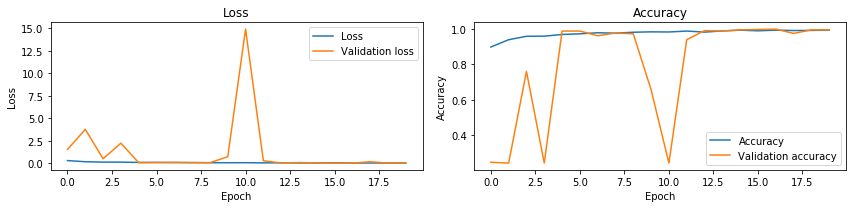

In [18]:
# Create evaluator instance
evaluator = Evaluator(history)

# Draw accuracy and loss charts
evaluator.plot_history()

# 4. Test Result

In [19]:
# Performance function
def performance_model(prediction,y_test):
    # Get Label in array
    list = []
    for i in y_test:
        list.append(i)
    arr = np.arange(len(y_test)).reshape(len(y_test),1)
    np.place(arr, arr>=0, list)
    # TN: True Nagetive, TP: True Positive, FP: False Positive, FN: False Nagetive
    i = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    while i < len(y_test):
        if prediction[i,0] == arr[i,0]:
            if prediction[i,0] == 0:
                TN += 1
            else:
                TP += 1
        else:
            if prediction[i,0] == 1:
                FP += 1
            else:
                FN += 1
        i += 1
    #  Accuracy (ACC), precision (PR), recall (RC),and F-score(FS)
    ACC = (TN+TP)/(TN+TP+FP+FN)
    PR = TP/(TP+FP)
    RC = TP/(TP+FN)
    FS = 2*(PR*RC)/(PR+RC)
    return(ACC,PR,RC,FS,TN,TP,FN,FP)

In [21]:
prediction = model.predict(X_test)

In [23]:
np.place(prediction,prediction>=0.5,1)
np.place(prediction,prediction<0.5,0)

In [25]:
prediction.shape

(453, 1)

In [26]:
#X_train, X_test, y_train, y_test
ACC,PR,RC,FS,TN,TP,FN,FP = performance_model(prediction,y_test)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)
print('True Positive: ',TP)
print('True Negative: ',TN)
print('False Positive: ',FP)
print('False Negative: ',FN)

Accuracy:  0.9911699779249448
Precision: 1.0
Recall:  0.9649122807017544
F-score:  0.9821428571428572
True Positive:  110
True Negative:  339
False Positive:  0
False Negative:  4
